## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm == 0.4.5  # 0.3.2 does not work in Colab
    !git clone https: // github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')


### Define utils

In [34]:
%autoreload 2

# define the utils


imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    image = image.detach().cpu()
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def show_map(m, title=""):
    assert len(m.shape) == 2
    m = m.detach().cpu()
    plt.imshow(m, cmap="viridis")
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    pprint(msg)
    print(f"Model has inference mask ratio {model.inference_mask_ratio}")
    return model


def run_one_image(img, model, threshold=0.5):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    result = model.inference(x.float(), threshold=threshold)
    pprint(result)
    x = torch.einsum('nchw->nhwc', x)
    y = result["preds"]
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    loss_maps = result["loss_maps"].detach().cpu()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 3, 1)
    show_image(x[0], "original")

    plt.subplot(1, 3, 2)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 3, 3)
    show_map(loss_maps[0], "loss map")

    plt.show()
    return result

### Load a pre-trained MAE model

In [35]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
import os

chkpt_dir = "../../output_1400ep/checkpoint-1400.pth"
# chkpt_dir = "../../output_test_ema/checkpoint-9.pth"
assert os.path.exists(chkpt_dir)
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch14')
print('Model loaded.')


_IncompatibleKeys(missing_keys=[], unexpected_keys=['loss_mean', 'loss_sqrd_mean'])
Model has inference mask ratio 0.25
Model loaded.


### Load an image

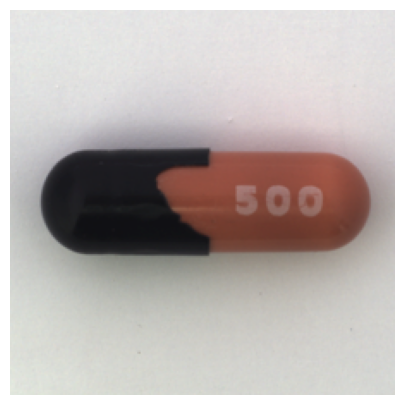

In [43]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# # img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
img = Image.open("../../data/capsule/test/bad/crack_010.png")
# img = Image.open("../../data/capsule/test/good/010.png")
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Run MAE on the image

MAE with pixel reconstruction:


C:\Users\lucfr\AppData\Local\Temp\ipykernel_34908\1631174956.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


{'anomaly_scores': 0.6221752166748047,
 'decisions': True,
 'images': tensor([[[[1.8037, 1.7865, 1.7865,  ..., 1.7523, 1.7523, 1.7352],
          [1.7523, 1.8037, 1.8208,  ..., 1.7523, 1.7865, 1.7180],
          [1.7865, 1.8379, 1.7865,  ..., 1.7180, 1.7352, 1.7352],
          ...,
          [1.8208, 1.7865, 1.7865,  ..., 1.5125, 1.5468, 1.5639],
          [1.7523, 1.7352, 1.7352,  ..., 1.5297, 1.5639, 1.5297],
          [1.7523, 1.7009, 1.7523,  ..., 1.5639, 1.4954, 1.5297]],

         [[1.9384, 2.0084, 1.9734,  ..., 1.9209, 1.9209, 1.8683],
          [1.9384, 2.0084, 1.9559,  ..., 1.9209, 1.9559, 1.8508],
          [1.9734, 1.9384, 1.9384,  ..., 1.8859, 1.9384, 1.8859],
          ...,
          [2.0609, 2.0259, 2.0434,  ..., 1.7108, 1.6933, 1.7458],
          [1.9909, 1.9909, 1.9909,  ..., 1.7458, 1.6933, 1.6933],
          [2.0084, 2.0084, 1.9909,  ..., 1.7458, 1.7108, 1.6933]],

         [[2.1171, 2.1868, 2.1868,  ..., 2.1694, 2.1520, 2.1694],
          [2.1868, 2.1868, 2.1868,  ..

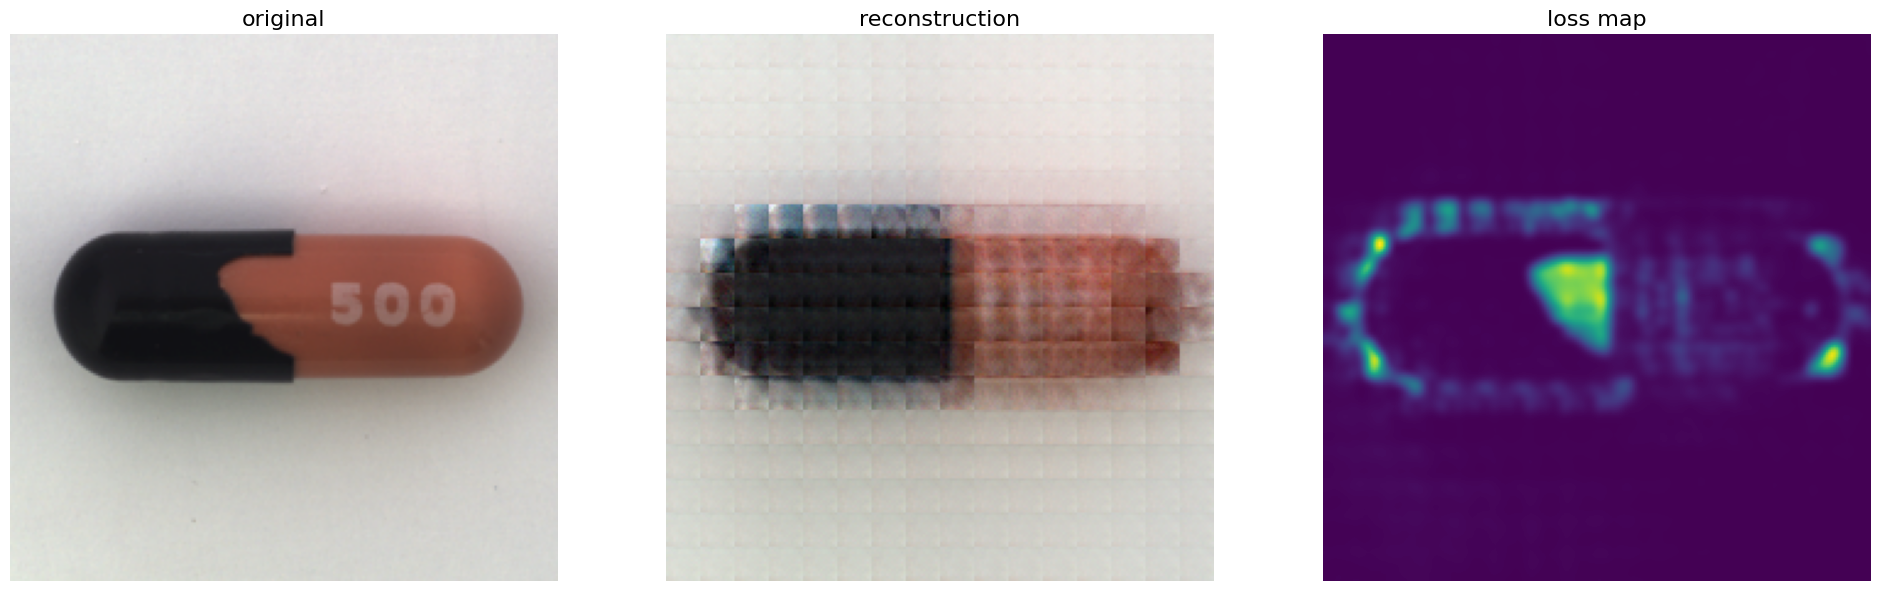

In [44]:
%autoreload 2 
from mae import models_mae

print('MAE with pixel reconstruction:')
result = run_one_image(torch.tensor(img, device="cuda"), model_mae.to("cuda"), threshold=0.6)

tensor([0.0011, 0.0011, 0.0005,  ..., 0.0004, 0.0012, 0.0013])


(array([4.7059e+04, 1.3410e+03, 5.4200e+02, 3.9000e+02, 3.3200e+02,
        3.6600e+02, 9.9000e+01, 3.3000e+01, 9.0000e+00, 5.0000e+00]),
 array([1.46385282e-04, 7.55543038e-02, 1.50962219e-01, 2.26370141e-01,
        3.01778048e-01, 3.77185971e-01, 4.52593893e-01, 5.28001785e-01,
        6.03409708e-01, 6.78817630e-01, 7.54225552e-01]),
 <BarContainer object of 10 artists>)

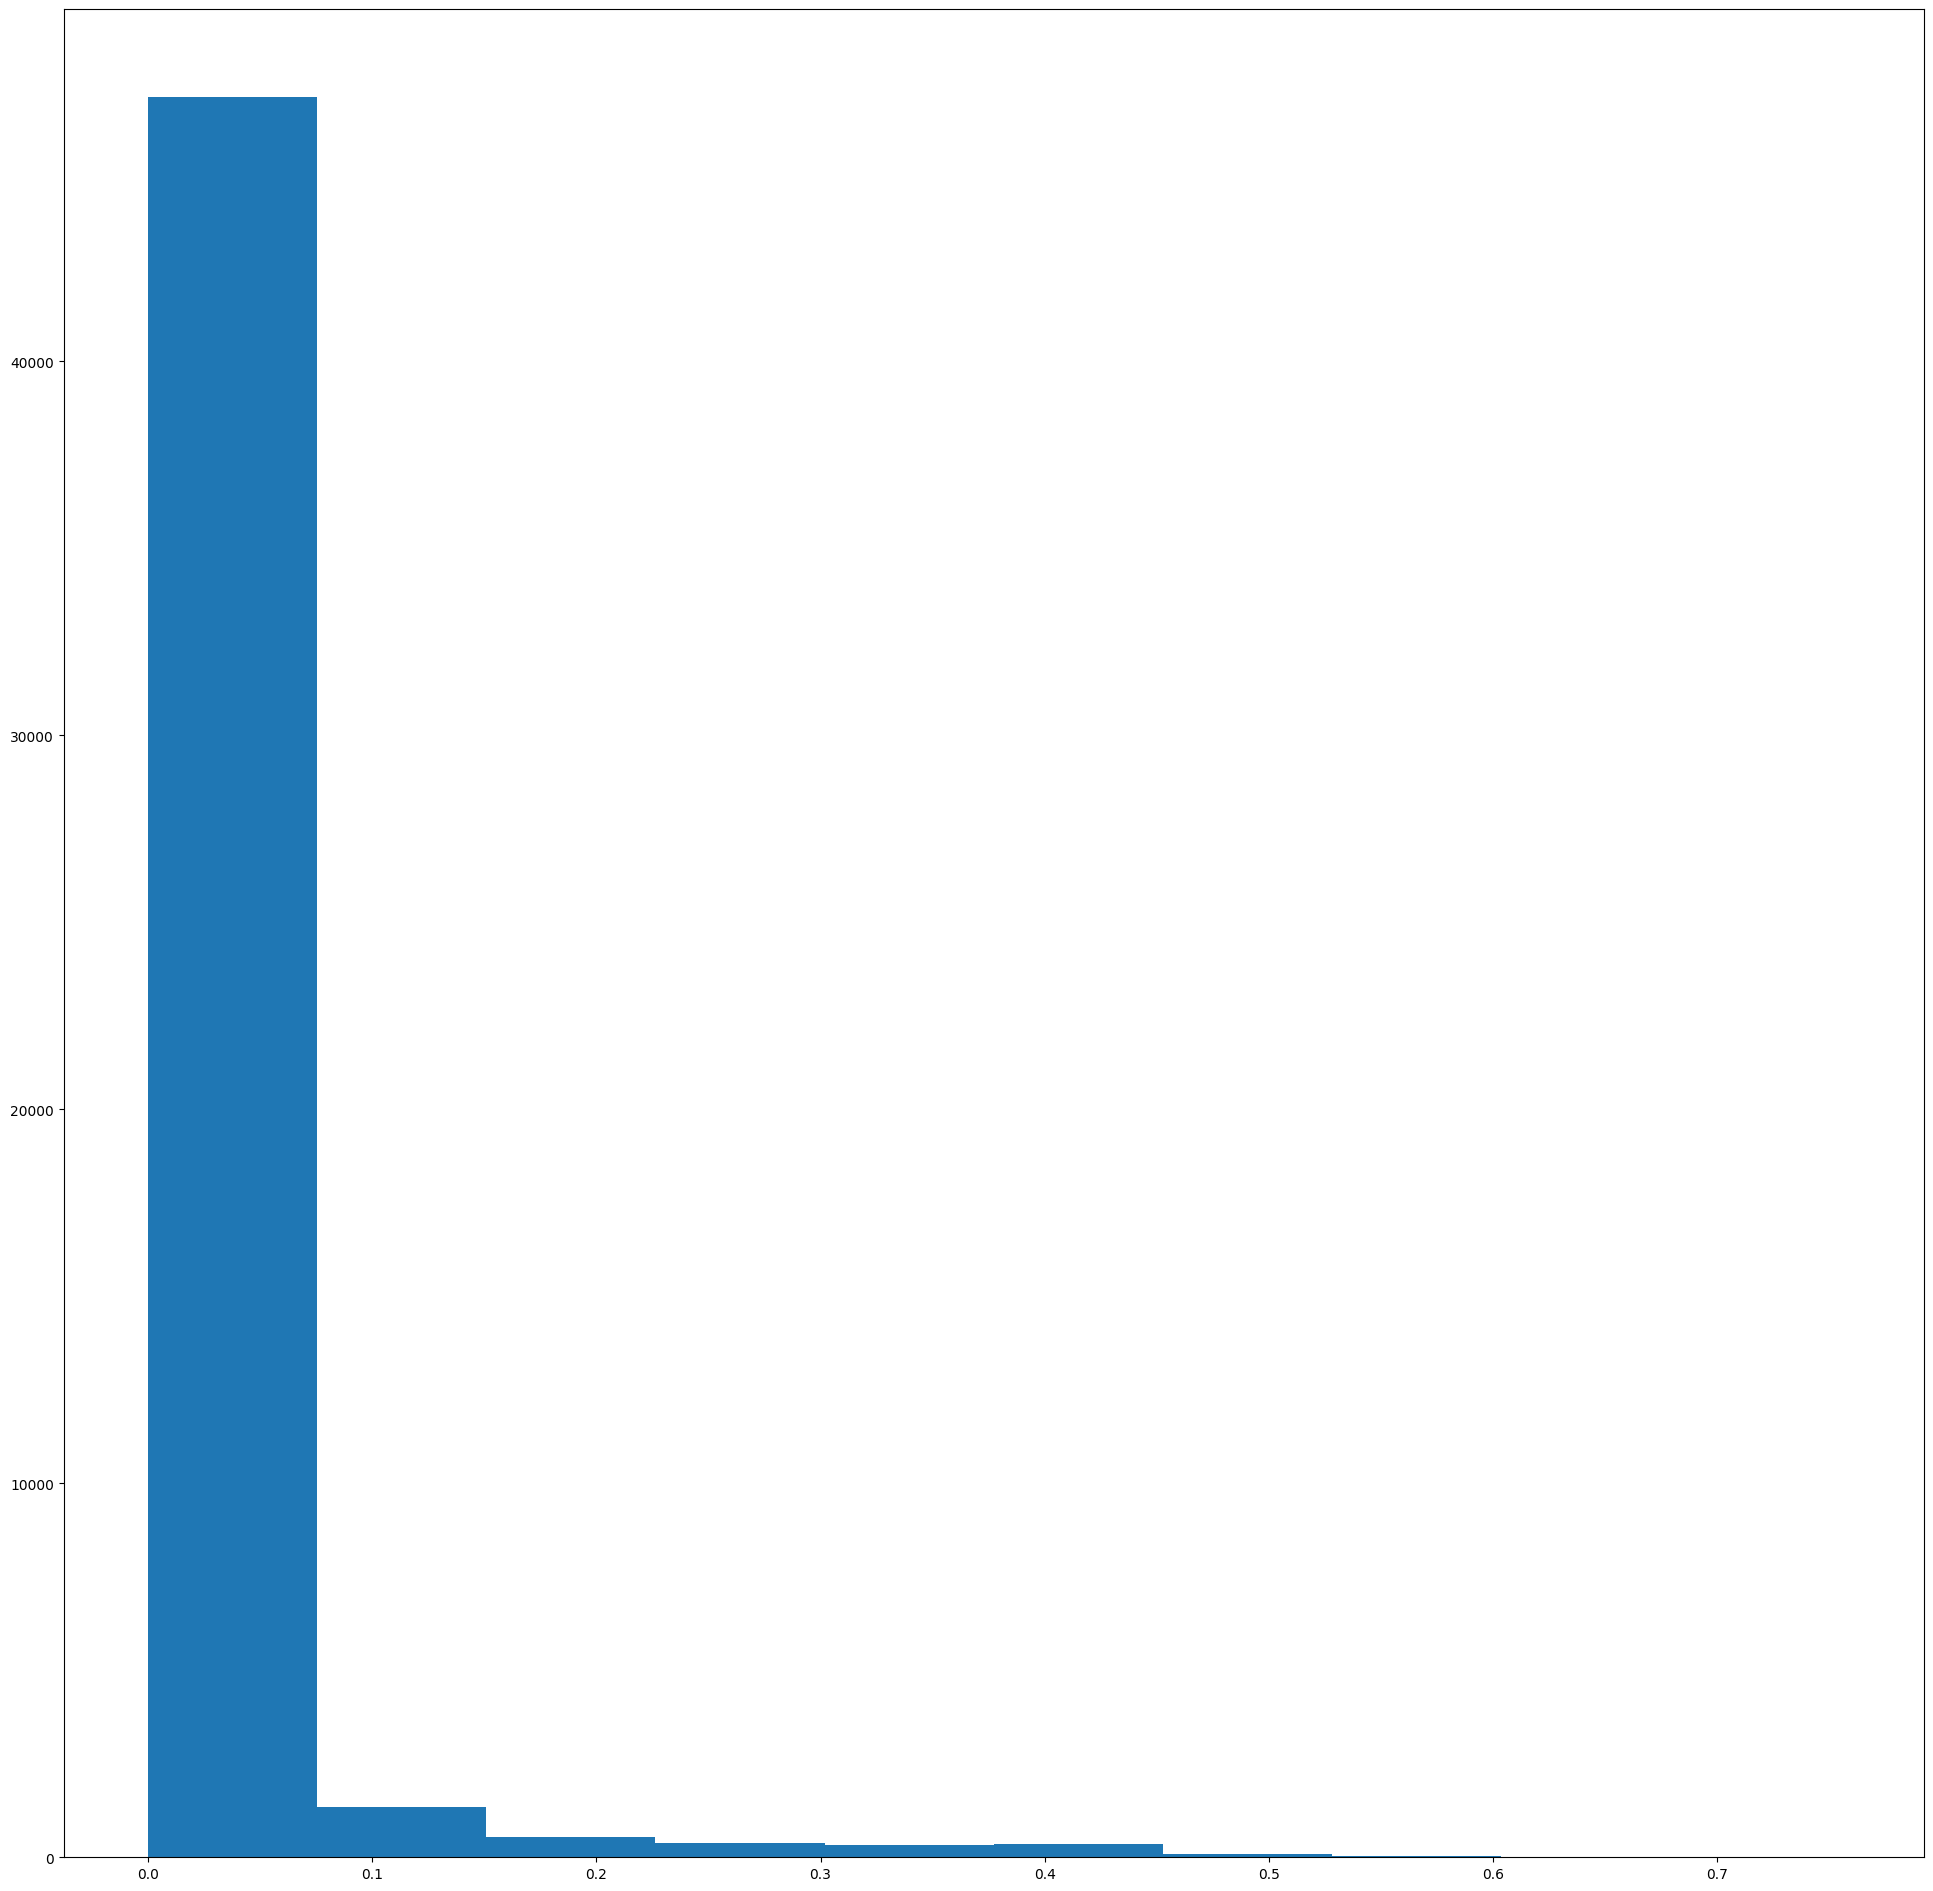

In [26]:
loss_map = result["loss_maps"].detach().cpu()
print(loss_map.flatten())
plt.hist(x=result["loss_maps"].flatten().cpu())


### Load another pre-trained MAE model

In [42]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https: // dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

[autoreload of models_mae failed: Traceback (most recent call last):
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "D:\experiments\mae-ad\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
Va

AssertionError: 

### Run MAE on the image

MAE with extra GAN loss:


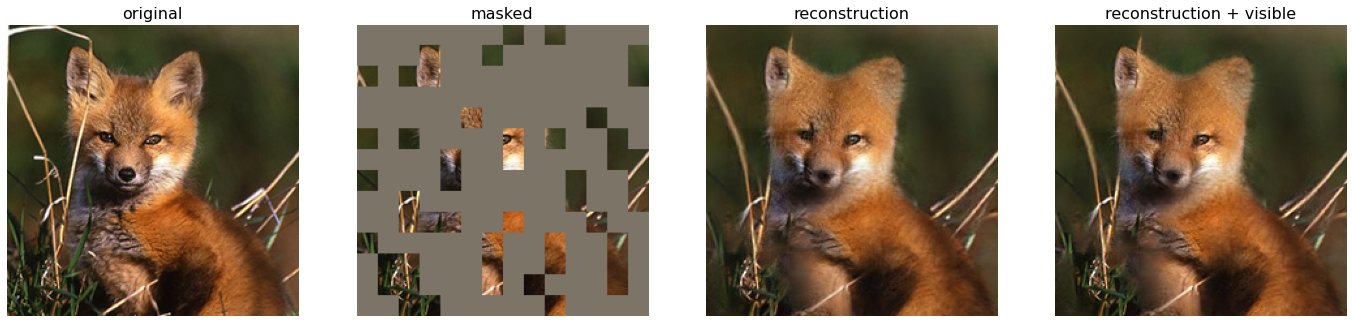

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)